In [2]:
from ultralytics import YOLO
import torch

# Load model
model = YOLO("yolov8n.pt")

# Load your image as a PyTorch tensor
import cv2
import numpy as np

img = cv2.imread("/shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video20_006.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.from_numpy(img).permute(2,0,1).float().unsqueeze(0) / 255.0  # [1,3,H,W]

# Forward pass (raw outputs)
with torch.no_grad():
    outputs = model.model(img)   # This gives raw predictions


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 24 but got size 23 for tensor number 1 in the list.

In [19]:
import torch, cv2, numpy as np
from ultralytics import YOLO
import torch.nn.functional as F
import math

# model = YOLO("yolov8n.pt")
model = YOLO("yolov8_surgery.pt")
net = model.model.eval()

# Get stride from the model (usually 32)
stride = int(net.stride.max().item())  # e.g., 32

# Load image (BGR -> RGB)
img0 = cv2.imread("/shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video20_006.png")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)

# Option A: simple resize to a square that's a multiple of stride (e.g., 640)
target = 640  # choose your size (multiple of stride)
target = (target // stride) * stride
img = cv2.resize(img0, (target, target), interpolation=cv2.INTER_LINEAR)

# Option B (letterbox-style): keep aspect, pad to nearest multiple of stride
# Uncomment this block if you prefer padding over squashing
# h0, w0 = img0.shape[:2]
# scale = min(target / h0, target / w0)
# nh, nw = int(round(h0 * scale)), int(round(w0 * scale))
# resized = cv2.resize(img0, (nw, nh), interpolation=cv2.INTER_LINEAR)
# pad_h = (math.ceil(nh / stride) * stride) - nh
# pad_w = (math.ceil(nw / stride) * stride) - nw
# top, bottom = pad_h // 2, pad_h - pad_h // 2
# left, right = pad_w // 2, pad_w - pad_w // 2
# img = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114,114,114))

# To tensor [1,3,H,W], float32, 0..1
tensor = torch.from_numpy(img).permute(2,0,1).contiguous().float().unsqueeze(0) / 255.0

# Device / dtype as you like
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
tensor = tensor.to(device)

with torch.no_grad():
    raw = net(tensor)  # raw model outputs (pre-NMS)


FileNotFoundError: [Errno 2] No such file or directory: 'yolov8_surgery.pt'

In [5]:
len(raw)

2

In [6]:
raw[0].shape

torch.Size([1, 84, 8400])

In [8]:
len(raw[1])

3

In [10]:
raw[1][0].shape

torch.Size([1, 144, 80, 80])

In [11]:
raw[1][1].shape

torch.Size([1, 144, 40, 40])

In [12]:
raw[1][2].shape

torch.Size([1, 144, 20, 20])

In [13]:
import torch
from torchvision.ops import nms  # or write your own

pred = raw[0]                # [B, 4+nc, N]
pred = pred.transpose(1, 2)  # [B, N, 4+nc]
boxes_xywh = pred[..., :4]   # [B, N, 4]  (pixel coords at network scale, e.g. 640x640)
cls_logits = pred[..., 4:]   # [B, N, 80]
cls_scores = cls_logits.sigmoid()

# If you want a single score per box (best class):
scores, labels = cls_scores.max(dim=-1)  # [B, N], [B, N]

# Convert xywh -> xyxy for NMS
def xywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    return torch.stack([x_c - w/2, y_c - h/2, x_c + w/2, y_c + h/2], dim=-1)

boxes_xyxy = xywh_to_xyxy(boxes_xywh[0])  # [N,4]
scores = scores[0]
labels = labels[0]

# Filter low scores
conf_thres = 0.25
keep = scores > conf_thres
boxes_xyxy = boxes_xyxy[keep]
scores = scores[keep]
labels = labels[keep]

# Class-aware NMS (per-class)
final_boxes = []
final_scores = []
final_labels = []
iou_thres = 0.5
for c in torch.unique(labels):
    idx = torch.where(labels == c)[0]
    keep_idx = nms(boxes_xyxy[idx], scores[idx], iou_thres)
    final_boxes.append(boxes_xyxy[idx][keep_idx])
    final_scores.append(scores[idx][keep_idx])
    final_labels.append(labels[idx][keep_idx])

final_boxes = torch.cat(final_boxes, 0)   # [M,4] in xyxy @ network scale
final_scores = torch.cat(final_scores, 0) # [M]
final_labels = torch.cat(final_labels, 0) # [M]


In [14]:
final_labels

tensor([ 0,  0,  0,  ..., 79, 79, 79], device='cuda:0')

In [15]:
len(final_labels)

1546

In [20]:
# COCO class names from ultralytics
# from ultralytics.yolo.utils import yaml_load
# names = yaml_load("https://raw.githubusercontent.com/ultralytics/ultralytics/main/ultralytics/cfg/datasets/coco.yaml")['names']
names = model.names
# After NMS you have:
# final_boxes [M,4]
# final_scores [M]
# final_labels [M]  # ints in 0..79

for box, score, cls in zip(final_boxes, final_scores, final_labels):
    x1, y1, x2, y2 = box.tolist()
    label = names[int(cls)]
    print(f"{label} {score:.2f} at [{x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f}]")
    break


person 0.55 at [3.6,1.2,632.9,592.1]


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

best.pt:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]


image 1/1 /shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video20_006.png: 384x640 (no detections), 32.6ms
Speed: 5.9ms preprocess, 32.6ms inference, 17.3ms postprocess per image at shape (1, 3, 384, 640)


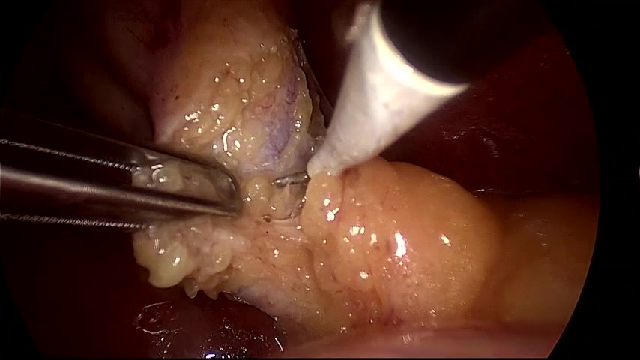

In [1]:
from ultralytics import YOLO
from huggingface_hub import snapshot_download
import os

# Load model from Hugging Face Hub
repo_id = "JJJHHHH/cloth_surgical_mask_detection_yolov8"
model_dir = snapshot_download(repo_id)
model = YOLO(os.path.join(model_dir, "best.pt"))

# Run inference on an image
results = model("/shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video20_006.png", conf=0.5, iou=0.6)
results[0].show()



image 1/1 /shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video01_006.png: 384x640 (no detections), 7.4ms
Speed: 1.5ms preprocess, 7.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


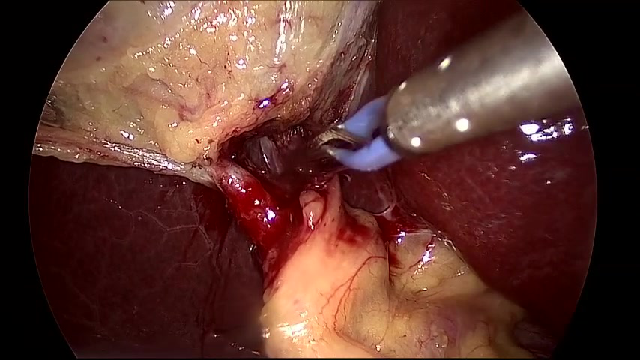

In [3]:
# Run inference on an image
results = model("/shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video01_006.png", conf=0.5, iou=0.6)
results[0].show()

In [5]:
results[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'cloth', 1: 'surgical'}
obb: None
orig_img: array([[[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 3],
        [0, 0, 3],
        [0, 0, 3]],

       [[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 3],
        [0, 0, 3],
        [0, 0, 3]],

       [[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 3],
        [0, 0, 3],
        [0, 0, 3]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
orig_shape